In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Veri yükleme
train_df = pd.read_csv('PM_train.csv')
test_df = pd.read_csv('PM_test.csv')
truth_df = pd.read_csv('PM_truth.csv')

In [3]:
# Veri ön işleme
def preprocess_data(df):
    # Gereksiz sütunları kaldır
    df = df.drop(['setting3', 's1', 's5', 's10', 's16', 's18', 's19'], axis=1)
    
    # Her motor için son cycle'ı bul
    last_cycles = df.groupby('id')['cycle'].max().reset_index()
    last_cycles.columns = ['id', 'max_cycle']
    
    # Her satır için RUL (Remaining Useful Life) hesapla
    df = pd.merge(df, last_cycles, on='id', how='left')
    df['RUL'] = df['max_cycle'] - df['cycle']
    
    return df

train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

In [4]:
# Özellik seçimi
features = ['setting1', 'setting2', 'cycle'] + [f's{i}' for i in range(2, 22) if i not in [5, 10, 16, 18, 19]]
X_train = train_df[features]
y_train = train_df['RUL']

In [5]:
# Veriyi ölçeklendir
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [6]:

# Model eğitimi
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [7]:
# Test verisi için tahminler
X_test = test_df[features]
X_test_scaled = scaler.transform(X_test)
test_df['RUL_predicted'] = model.predict(X_test_scaled)

In [8]:
# Her motor için son cycle'daki RUL tahminini al
final_predictions = test_df.groupby('id')['RUL_predicted'].last().reset_index()
final_predictions = pd.merge(final_predictions, truth_df, on='id', how='left')

In [9]:
# Truth verisindeki gerçek RUL değerlerini kullan
if 'RUL' in truth_df.columns:
    true_rul_column = 'RUL'
elif 'cycle' in truth_df.columns:
    true_rul_column = 'cycle'
    final_predictions[true_rul_column] = final_predictions[true_rul_column].astype(float)
else:
    raise ValueError("Truth verisinde RUL veya cycle sütunu bulunamadı.")

In [10]:
# Performans değerlendirme
mse = mean_squared_error(final_predictions[true_rul_column], final_predictions['RUL_predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(final_predictions[true_rul_column], final_predictions['RUL_predicted'])

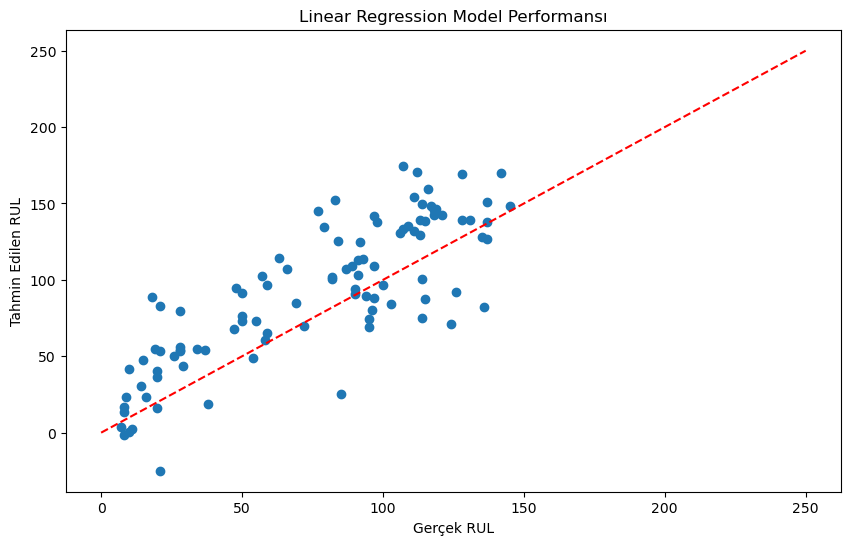

In [11]:
# Tahmin vs Gerçek değer grafiği
plt.figure(figsize=(10, 6))
plt.scatter(final_predictions[true_rul_column], final_predictions['RUL_predicted'])
plt.plot([0, 250], [0, 250], 'r--')
plt.xlabel('Gerçek RUL')
plt.ylabel('Tahmin Edilen RUL')
plt.title('Linear Regression Model Performansı')
plt.show()

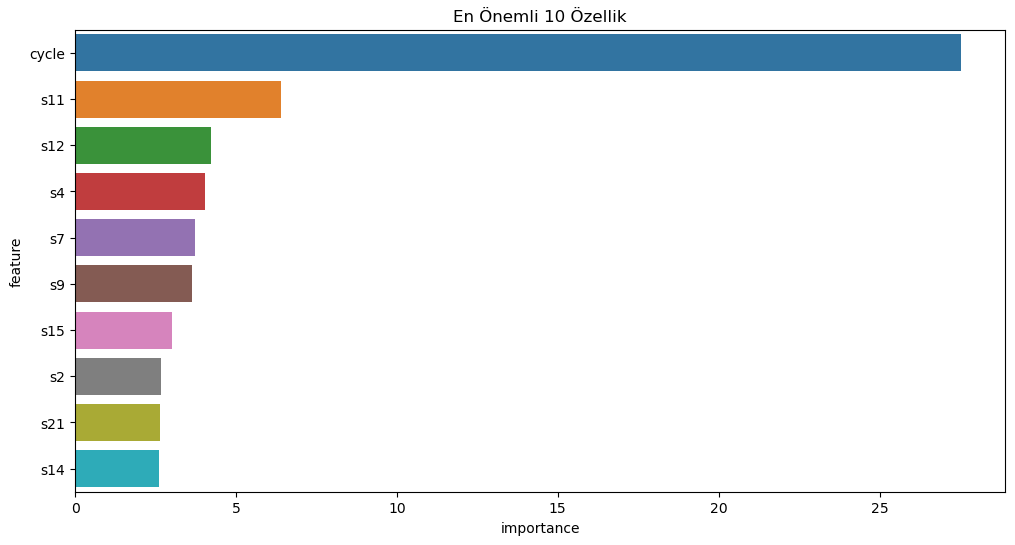

In [12]:

# Özellik önem sıralaması
feature_importance = pd.DataFrame({'feature': features, 'importance': abs(model.coef_)})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('En Önemli 10 Özellik')
plt.show()

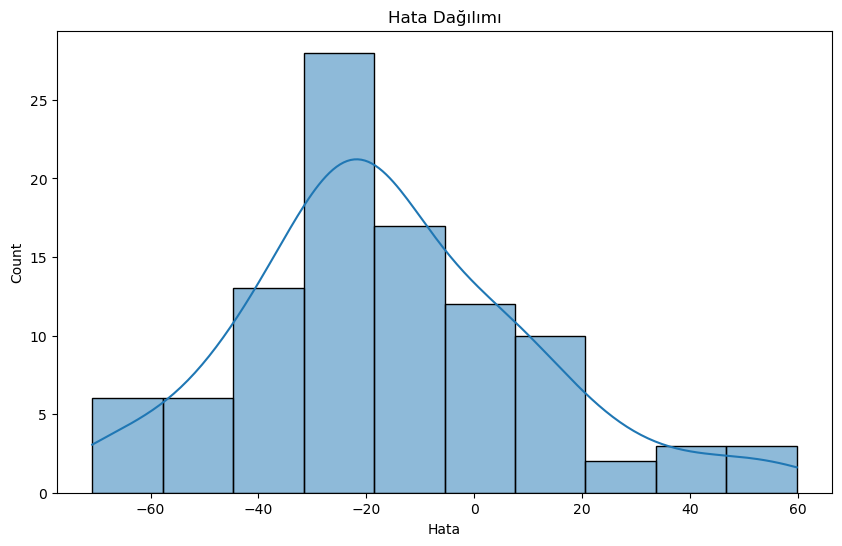

In [13]:
# Hata analizi
final_predictions['error'] = final_predictions[true_rul_column] - final_predictions['RUL_predicted']
plt.figure(figsize=(10, 6))
sns.histplot(final_predictions['error'], kde=True)
plt.title('Hata Dağılımı')
plt.xlabel('Hata')
plt.show()

In [14]:
# Sonuçları kaydet
final_predictions.to_csv('linear_regression_predictions.csv', index=False)

In [15]:
# İlk 10 tahmini göster
print("\nİlk 10 tahmin:")
print(final_predictions[['id', true_rul_column, 'RUL_predicted', 'error']].head(10))


İlk 10 tahmin:
   id  cycle  RUL_predicted      error
0   1  112.0     170.808795 -58.808795
1   2   98.0     138.048904 -40.048904
2   3   69.0      84.979079 -15.979079
3   4   82.0     102.022632 -20.022632
4   5   91.0     113.250742 -22.250742
5   6   93.0     113.877251 -20.877251
6   7   91.0     103.180913 -12.180913
7   8   95.0      74.567241  20.432759
8   9  111.0     131.765187 -20.765187
9  10   96.0      80.530884  15.469116


In [16]:
def format_maintenance_prediction(row):
    id = row['id']
    predicted_rul = row['RUL_predicted']
    
    # RUL değerini saate çevir (varsayalım ki her cycle 1 saate denk geliyor)
    hours = round(predicted_rul)
    
    if hours <= 0:
        return f"Motor ID {id}: ACİL BAKIM GEREKLİ! Tahmini kalan ömür süresi aşılmış."
    elif hours < 50:
        return f"Motor ID {id}: DİKKAT! Yakın zamanda bakım gerekli. Tahmini kalan süre: {hours} saat."
    elif hours < 100:
        return f"Motor ID {id}: Bakım planlanmalı. Tahmini kalan süre: {hours} saat."
    else:
        return f"Motor ID {id}: İyi durumda. Tahmini kalan süre: {hours} saat."

In [17]:
# Bu fonksiyonu final_predictions DataFrame'ine uygula
final_predictions['maintenance_message'] = final_predictions.apply(format_maintenance_prediction, axis=1)

In [18]:
print("\nBakım Tahminleri:")
for message in final_predictions['maintenance_message']:
    print(message)


Bakım Tahminleri:
Motor ID 1.0: İyi durumda. Tahmini kalan süre: 171 saat.
Motor ID 2.0: İyi durumda. Tahmini kalan süre: 138 saat.
Motor ID 3.0: Bakım planlanmalı. Tahmini kalan süre: 85 saat.
Motor ID 4.0: İyi durumda. Tahmini kalan süre: 102 saat.
Motor ID 5.0: İyi durumda. Tahmini kalan süre: 113 saat.
Motor ID 6.0: İyi durumda. Tahmini kalan süre: 114 saat.
Motor ID 7.0: İyi durumda. Tahmini kalan süre: 103 saat.
Motor ID 8.0: Bakım planlanmalı. Tahmini kalan süre: 75 saat.
Motor ID 9.0: İyi durumda. Tahmini kalan süre: 132 saat.
Motor ID 10.0: Bakım planlanmalı. Tahmini kalan süre: 81 saat.
Motor ID 11.0: İyi durumda. Tahmini kalan süre: 109 saat.
Motor ID 12.0: Bakım planlanmalı. Tahmini kalan süre: 71 saat.
Motor ID 13.0: Bakım planlanmalı. Tahmini kalan süre: 69 saat.
Motor ID 14.0: İyi durumda. Tahmini kalan süre: 133 saat.
Motor ID 15.0: İyi durumda. Tahmini kalan süre: 152 saat.
Motor ID 16.0: İyi durumda. Tahmini kalan süre: 125 saat.
Motor ID 17.0: Bakım planlanmalı. Tah

In [19]:
# Sonuçları kaydet
final_predictions.to_csv('maintenance_predictions.csv', index=False)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def calculate_accuracy(y_true, y_pred, threshold=100):
    """
    Belirli bir eşik değerine göre accuracy hesaplar.
    threshold'dan küçük değerler "bakım gerekli" olarak sınıflandırılır.
    """
    y_true_class = (y_true <= threshold).astype(int)
    y_pred_class = (y_pred <= threshold).astype(int)
    
    accuracy = accuracy_score(y_true_class, y_pred_class)
    conf_matrix = confusion_matrix(y_true_class, y_pred_class)
    class_report = classification_report(y_true_class, y_pred_class)
    
    return accuracy, conf_matrix, class_report

# Gerçek RUL değerleri ve tahminler
y_true = final_predictions[true_rul_column].values
y_pred = final_predictions['RUL_predicted'].values

# Accuracy, confusion matrix ve classification report hesapla
accuracy, conf_matrix, class_report = calculate_accuracy(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Farklı eşik değerleri için accuracy hesapla
thresholds = [50, 100, 150, 200]
for threshold in thresholds:
    acc, _, _ = calculate_accuracy(y_true, y_pred, threshold)
    print(f"Accuracy (threshold={threshold}): {acc:.4f}")

# RMSE ve R-squared skorlarını da göster
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\nRoot Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

Accuracy: 0.7600

Confusion Matrix:
[[27  6]
 [18 49]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.82      0.69        33
           1       0.89      0.73      0.80        67

    accuracy                           0.76       100
   macro avg       0.75      0.77      0.75       100
weighted avg       0.79      0.76      0.77       100

Accuracy (threshold=50): 0.8200
Accuracy (threshold=100): 0.7600
Accuracy (threshold=150): 0.9200
Accuracy (threshold=200): 1.0000

Root Mean Squared Error: 31.2505
R-squared Score: 0.4345


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
